In [1]:
import harmonica as hm
import numpy as np
import verde as vd
import matplotlib.pyplot as plt

import magali as mg

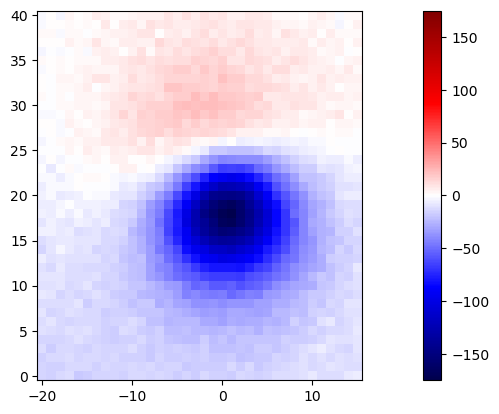

In [2]:
coordinates = vd.grid_coordinates(
    region=[-20, 15, 0, 40],
    spacing=1,
    extra_coords=5,
)
dipole_coordinates = (0, 20, -5)
true_inclination = 45
true_declination = -15
true_intensity = 1e-15
true_moment = hm.magnetic_angles_to_vec(
    inclination=true_inclination,
    declination=true_declination,
    intensity=true_intensity,
)
data = mg.dipole_bz(coordinates, dipole_coordinates, true_moment)
data += mg.dipole_bz(
    coordinates, [-50, -50, -100], hm.magnetic_angles_to_vec(2e-13, 90, 0)
)
data += np.random.default_rng(42).normal(0, 2, data.shape)

plt.figure()
scale = vd.maxabs(data)
plt.pcolormesh(*coordinates[:2], data, cmap="seismic", vmin=-scale, vmax=scale)
plt.colorbar()
plt.axis("scaled")
plt.show()

In [3]:
grid = vd.make_xarray_grid(
    coordinates, data, data_names="bz", extra_coords_names="z", dims=("y", "x")
)
grid = grid.assign({
    name: deriv for name, deriv in zip(
        ["deriv_x", "deriv_y", "deriv_z"], mg.gradient(grid.bz),
    )
})
table = vd.grid_to_table(grid)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [4]:
euler = hm.EulerDeconvolution(structural_index=3).fit(
    tuple(c.ravel() for c in coordinates), (table.bz, table.deriv_x, table.deriv_y, table.deriv_z)
)
linear = mg.MagneticMomentBz(euler.location_).fit(coordinates, data - euler.base_level_)
print(dipole_coordinates)
print(euler.location_)
print(true_intensity, true_inclination, true_declination)
print(hm.magnetic_vec_to_angles(*linear.dipole_moment_))

(0, 20, -5)
[ 0.04041674 20.27141785  3.27582947]
1e-15 45 -15
(np.float64(7.435539974484376e-18), np.float64(40.833856869692895), np.float64(-12.99306911500106))


In [15]:
nonlinear_model = mg.NonlinearMagneticDipoleBz(initial_location=euler.location_)
nonlinear_model.fit(coordinates, data - euler.base_level_)
print(dipole_coordinates)
print(nonlinear_model.location_)
print(true_intensity, true_inclination, true_declination)
print(hm.magnetic_vec_to_angles(*nonlinear_model.dipole_moment_))

(0, 20, -5)
[ 0.02455657 20.40394    -4.86769877]
1e-15 45 -15
(np.float64(1.0030780752355289e-15), np.float64(39.341928608426514), np.float64(-11.438066249756249))


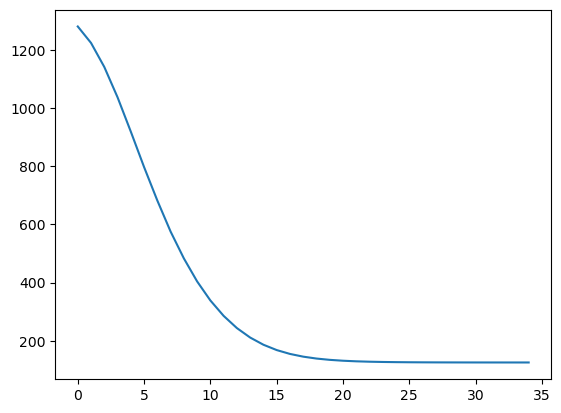

In [21]:
plt.plot(nonlinear_model.misfit_)